In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib
import datetime
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D,concatenate,Input,Activation,add,GlobalAveragePooling2D,Reshape,Multiply
from tensorflow.keras.utils import plot_model

In [2]:
def dataModelPreparation():
    path = './dataset/mnist.npz'
    f = np.load(path)
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    f.close()

    h = x_train.shape[1] // 2
    w = x_train.shape[2] // 2

    x_train = np.expand_dims(x_train, axis=-1)
    x_train = tf.image.resize(x_train, [h, w]).numpy()  # if we want to resize
    x_test = np.expand_dims(x_test, axis=-1)
    x_test = tf.image.resize(x_test, [h, w]).numpy()  # if we want to resize

    n_classes = 10


    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255.0
    x_test /= 255.0

    yy = y_test
    y_ind = yy.argsort()
    '''
        argsort():
            将矩阵a按照axis排序，并返回排序后的下标
    '''

    label_mask = np.unique(y_test)
    '''
        对于一维数组或者列表，np.unique() 函数 去除其中重复的元素 ，并按元素 由小到大 返回一个新的无元素重复的元组或者列表。
    '''
    label_count = {}
    for v in label_mask:
        label_count[v] = np.sum(y_test == v)
    print("label_mask值为：")
    print(label_mask)
    print("统计结果：")
    print(label_count)

    example_images = []
    total_label = 0
    for i in range(0, 10):
        example_images += [x_test[y_ind[total_label:total_label + 10]]]
        total_label += label_count[i]
    # example_images = [x_test[y_ind[i*1100:i*1100+100]] for i in range(0, 10)]
    example_images = np.vstack(example_images)
    '''
        np.vstack() 按垂直方向（行顺序）堆叠数组构成一个新的数组
    '''

    # Work 1： 建立one-hot标签及训练和测试数据，注意，batchsize为100###
    y_train = tf.one_hot(y_train, n_classes)
    y_test = tf.one_hot(y_test, n_classes)

    train_datasets = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(100)

    test_datasets = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(100)
    ################################################################

    # Work 2： 建立通道注意力模块#######################################
    def SeNetBlock(input,reduction=4):
        channels = 16# 得到input的通道数量c
        avg_x = tf.keras.layers.GlobalAvgPool2D(name='global_average_pooling2d')(input)#先对feature的每个通道进行全局平均池化Global Average Pooling 得到通道描述子（Squeeze）
        x= tf.keras.layers.Reshape((1, 1, 16), name='reshape')(avg_x)#形状匹配做点啥？考虑global average pooling后的特征形状是否适合充当conv2d的输入
        x = tf.keras.layers.Conv2D(filters=int(channels)//reduction, kernel_size=1, strides=1, padding='valid', activation='relu', name='conv2d_1')(x)#接着做reduction，用int(channels)//reduction个卷积核对 avg_x做1x1的点卷积, 其他参数：relu,valid
        x = tf.keras.layers.Conv2D(filters=int(channels), kernel_size=1, strides=1, padding='valid', name='conv2d_2')(x)#接着用int(channels)个卷积核个数对 x做1x1的点卷积，扩展x回到原来的通道个数,其他参数：不激活,valid
        cbam_feature = tf.keras.layers.Activation(activation='hard_sigmoid', name='activation')(x)#对x 做 sigmoid 激活得到通道权重，用'hard_sigmoid'
        return tf.keras.layers.Multiply(name='multiply')([input, cbam_feature]), cbam_feature#返回以cbam_feature 为scale，对feature做拉伸加权的结果，注意看网络结构图，这里需要用什么操作实现？
    ####################################################################

    inputs = tf.keras.Input(shape=(14, 14, 1), name='data')
    x = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid', name='conv2d')(inputs)

    # Work 3.1： 将通道注意力模块连入网络#################
    se, cb_feature = SeNetBlock(x)
    # output = tf.keras.layers.add([x, se])
    ##################################################
    # Work 3.2： 完成网络的剩余部分#################
    pool = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, name='max_pooling2d')(se)
    flatten = tf.keras.layers.Flatten(name='flatten')(pool)
    fc1 = tf.keras.layers.Dense(60, name='dense')(flatten)
    ##################################################
    outputs = tf.keras.layers.Dense(n_classes, activation='softmax', name='dense_1')(fc1)

    # Work 4： 利用tf.keras.Model建立两个模型，一个为完整的网络，用于训练；另一个用于输出通道注意力特征
    # 注意：两个模型的名称请从后面的代码里找
    cbam_feature_model = tf.keras.Model(inputs=inputs, outputs=cb_feature, name='cbam_feature')
    senet_lenet = tf.keras.Model(inputs=inputs, outputs=outputs, name='se_net')
    ############################################################################################

    cbam_feature_output = cbam_feature_model(example_images).numpy()
    cbam_feature_matrix = cbam_feature_output.reshape((100, 16))

    plt.figure(num='cbam', figsize=(3, 8))
    plt.imshow(cbam_feature_matrix, cmap=plt.get_cmap('hot'))
    plt.colorbar()
    plt.savefig("./test_figure/step1/cbam.png")

    plot_model(senet_lenet, to_file='./test_figure/step1/senet_lenet.png', show_shapes=True,expand_nested=True)

    return train_datasets, test_datasets, senet_lenet, example_images

label_mask值为：
[0 1 2 3 4 5 6 7 8 9]
统计结果：
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


(<BatchDataset element_spec=(TensorSpec(shape=(None, 14, 14, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 14, 14, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>,
 array([[[[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         ...,
 
         [[0.        ],
          [0.        ],
          [0.        ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],
 
         [[0.        ],


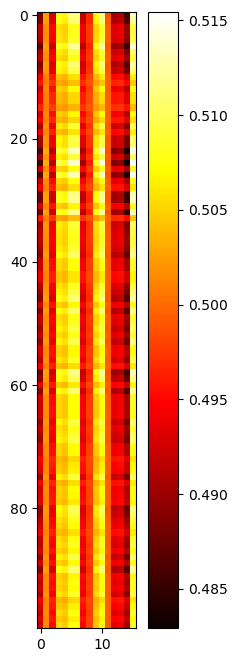

In [3]:
dataModelPreparation()

In [4]:
def test_fun():
    train_datasets, test_datasets, senet_lenet, example_images = dataModelPreparation()
    # Work 5： 完成模型的编译和训练###########################################
    senet_lenet.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss=tf.keras.losses.categorical_crossentropy,
        metrics=['acc']
    )

    history = senet_lenet.fit(
        train_datasets,
        validation_data=test_datasets,
        batch_size=64,
        epochs=1, # epoch数量不要改变！！！
        verbose=2
    )
    #########################################################################
    return senet_lenet, history

In [ ]:
test_fun()

label_mask值为：
[0 1 2 3 4 5 6 7 8 9]
统计结果：
{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
